In [1]:
!pip install gtfs-kit #install gtfs-kit which will be used to mine the gtfs (transit data)
import pandas as pd
import gtfs_kit as gk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 23.4 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sha256=4c73814ca0f2f13278fa3cd80eb42b96cb37a97faab5c8ad4a1e4b31c427910a
  Stored in directory: /root/.cache/pip/wheels/91/96/d0/3cfff4cc9a9e307cfc2b8fe4846c56d714b78bbe5f6da211a5
Successfully built json2html


In [2]:
#get google drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Final Project Files/Rail & Bus Combined GTFS Static.zip"#we can update this data since it is as of 27/Oct/2025
feed = gk.read_feed(path, dist_units = "km") #load gtfs from WMATA

stops.txt - provides the all the metro and bus stops data:
Important Fields:

- location_type: has values for the type of location that the bus stop is at. We are primarily interested in actual stops a metro station or a bus stop not sub stops within a stop so we will filter and use "0" for bis stops and "1" for stations.

In [4]:
#the stops will likely be the nodes in the graph
stops_df = feed.stops
#bus stops are location_type = 0 or na
bus_stops = stops_df[(stops_df.location_type.isna()) | (stops_df.location_type == 0)]
#stations location_type =1
stations = stops_df[stops_df.location_type == 1]
print("Shape of stops dataframe:", bus_stops.shape)

Shape of stops dataframe: (7626, 14)


In [5]:
bus_stops[(bus_stops.stop_name == "Huntington Av+Biscayne Dr")]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,level_id,platform_code
1417,14218,5002008,Huntington Av+Biscayne Dr,<NA>,38.794838,-77.07235,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


"In GTFS, a route defines a specific path or line on a map, while a trip is a single, specific instance of a vehicle traveling along that route at a particular time. A route groups together all its associated trips, which are variations of the same route that might have different schedules, directions (like inbound vs. outbound), or operate on different days of the week."

Important Fields:
route_type : Indicates the type of transportation used on a route.

In [6]:
routes_df = feed.routes
print('Route Types:', routes_df.route_type.value_counts())
#route_type: 1 = metro, 3 = buses
routes_df[routes_df['route_type'] == 1]

Route Types: route_type
3    126
1      6
Name: count, dtype: Int64


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,as_route,route_text_color
14,BLUE,1,BL,Blue,<NA>,1,<NA>,0076C0,1,FFFFFF
85,GREEN,1,GR,Green,<NA>,1,<NA>,00A94F,1,FFFFFF
97,ORANGE,1,OR,Orange,<NA>,1,<NA>,F7941E,1,000000
128,RED,1,RD,Red,<NA>,1,<NA>,E31837,1,FFFFFF
130,SILVER,1,SV,Silver,<NA>,1,<NA>,A1A2A1,1,000000
131,YELLOW,1,YL,Yellow,<NA>,1,<NA>,FFD200,1,000000


In [7]:
trips_df = feed.trips
stop_times_df = feed.stop_times
shapes_df = feed.shapes

In [8]:
import datetime as dtt
#parse times

def parse_times(time):
    h, m, s = map(int, time.split(":"))
    days, h = divmod(h, 24)
    return pd.Timestamp("1900-01-01") + pd.to_timedelta(f"{days} days {h}:{m}:{s}") #adds days, hrs, mins, secs to date to allow for subtraction
    #using just time delta wouldn't work

#test parse times
print(parse_times("16:23:00"))
print(parse_times("24:25:00"))

1900-01-01 16:23:00
1900-01-02 00:25:00


In [ ]:
#final versions of table before graphing
#there are several trips that go in the same direction. Overall there are two directions: 0 - Travel in one direction (e.g. outbound travel).
#1 - Travel in the opposite direction (e.g. inbound travel).
#we do not need every single trip that occurs every single day so we will aggregate and maybe apply some frequency attributes later on

#we need a unique id for each unique route
trips_grouped = trips_df.groupby(by = ['route_id', 'direction_id'])['trip_id'].agg(list) #group by route and directions to get all trips for that direction
# trips_grouped_test
trips_info = trips_grouped.reset_index() #reset index
trips_info = trips_info.explode('trip_id', ignore_index= True) #one row per trip

trips_info = trips_info.merge(stop_times_df, left_on = 'trip_id', right_on = 'trip_id').sort_values(by = ['trip_id', 'stop_sequence'] )
trips_info = trips_info.groupby(by = ['route_id', 'direction_id', 'trip_id'])['stop_id'].agg(list).reset_index()
trips_info['stop_id'] = trips_info['stop_id'].apply(tuple)
trips_info = trips_info.drop_duplicates(['route_id', 'direction_id', 'stop_id'])
trips_info['unique_id'] = trips_info['route_id'] + trips_info['direction_id'].astype(str) + trips_info['trip_id']

trips_final = trips_info.loc[:, ['unique_id', 'route_id', 'direction_id', 'trip_id']].copy()
#add stop_times
trips_final = trips_final.merge(stop_times_df, left_on = 'trip_id', right_on = 'trip_id')

#a little cleaning of the dates
trips_final['arrival_time'] = trips_final['arrival_time'].apply(parse_times)
trips_final['departure_time'] =  trips_final['departure_time'].apply(parse_times)
trips_final['prev_stop_id'] = trips_final.groupby(by = ['unique_id'])['stop_id'].shift(1, fill_value = 'first')
trips_final

,unique_id,route_id,direction_id,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,prev_stop_id
0,A11010266070,A11,0,10266070,1900-01-01 14:26:00,1900-01-01 14:26:00,21629,2,<NA>,0,0,NaN,1,first
1,A11010266070,A11,0,10266070,1900-01-01 14:27:36,1900-01-01 14:27:36,14218,3,<NA>,0,0,NaN,0,21629
2,A11010266070,A11,0,10266070,1900-01-01 14:28:05,1900-01-01 14:28:05,11648,4,<NA>,0,0,NaN,0,14218
3,A11010266070,A11,0,10266070,1900-01-01 14:29:27,1900-01-01 14:29:27,11642,5,<NA>,0,0,NaN,0,11648
4,A11010266070,A11,0,10266070,1900-01-01 14:29:46,1900-01-01 14:29:46,14219,6,<NA>,0,0,NaN,0,11642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17169,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:36:00,1900-01-01 06:36:00,PF_C11_2,6,<NA>,0,0,5.9456,<NA>,PF_C10_2
17170,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:39:00,1900-01-01 06:39:00,PF_C12_C,7,<NA>,0,0,7.4669,<NA>,PF_C11_2
17171,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:40:00,1900-01-01 06:40:00,PF_C13_C,8,<NA>,0,0,8.1578,<NA>,PF_C12_C
17172,YELLOW19075098_20387,YELLOW,1,9075098_20387,1900-01-01 06:42:00,1900-01-01 06:42:00,PF_C14_2,9,<NA>,0,0,8.8642,<NA>,PF_C13_C


In [ ]:
stops_df['location_type'] = stops_df['location_type'].fillna(0) #na values are also bus stops

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#attempting to create a small graph
G = nx.MultiDiGraph()#create empty graph

usable_stops_df = stops_df[(stops_df['location_type'] == 0)]


nodes_info = []
#converting nodes data to dictionary for adding
for index, row in usable_stops_df.iterrows():
    #label location types
    if 'PF' in row['stop_id']:
        location_type = "Station"
    else:
        location_type = "Bus Stop"

    # print("adding node: ", index)#progress print
    node_id = row['stop_id']
    node_attributes = {"stop_name": row['stop_name'],
                       "stop_lat": row['stop_lat'],
                       "stop_lon": row['stop_lon'],
                       "stop_location_type": location_type,
                       "stop_wheelchair_accessible": row['wheelchair_boarding']}
    #add to nodes_info
    nodes_info.append((node_id, node_attributes))

print(f"Ensuring correct format: {nodes_info[:2]}")

#add nodes
G.add_nodes_from(nodes_info)

print(G)

Ensuring correct format: [('10000', {'stop_name': 'New Hampshire Av+Quebec St', 'stop_lat': 38.996655, 'stop_lon': -76.984741, 'stop_location_type': 'Bus Stop', 'stop_wheelchair_accessible': <NA>}), ('10001', {'stop_name': 'Riggs Rd+Ruatan St', 'stop_lat': 38.996704, 'stop_lon': -76.972763, 'stop_location_type': 'Bus Stop', 'stop_wheelchair_accessible': <NA>})]
MultiDiGraph with 7626 nodes and 0 edges


In [ ]:
#add edges, format: add_weighted_edges_from([(1, 2, 0.5), (3, 1, 0.75)]), (to, from, weight)
routes_list = trips_final['unique_id'].unique().tolist()
edges_info = []

for route in routes_list:
    temp_df =  trips_final[trips_final['unique_id'] == route].copy().sort_values(by = 'stop_sequence')
    prev_seq_num = temp_df.iloc[0]['stop_sequence'].item()
    print(f"{route} started")
    for index, row in temp_df.iterrows():
        # trip = row['trip_id']
        current_stop = row['stop_id']
        #handle first stops
        if row['prev_stop_id'] == "first":
            prev_stop = current_stop
        else:
            prev_stop = row['prev_stop_id']

        # print((prev_stop, current_stop))
        prev_dep_time = temp_df[(temp_df['stop_id'] == prev_stop) & (temp_df['stop_sequence'] == prev_seq_num)]['departure_time'].item()
        #calculate time between stops
        weight = (row['arrival_time'] - prev_dep_time).total_seconds()/60
        attributes = {"weight": weight,
                      "route": row['route_id'],
                      "direction": row['direction_id']}
        info = (prev_stop, current_stop, attributes)

        if info in edges_info:
            print(info, row['trip_id'])
            prev_seq_num = row['stop_sequence']
            continue

        edges_info.append(info)
        prev_seq_num = row['stop_sequence']

    # edges_info
    print(f"{route} complete")

G.add_edges_from(edges_info)

A11010266070 started
A11010266070 complete
A1111003020 started
A1111003020 complete
A12010268020 started
A12010268020 complete
A12110140010 started
A12110140010 complete
A1X01000070 started
A1X01000070 complete
A1X110004070 started
A1X110004070 complete
A2501064020 started
A2501064020 complete
A25113353020 started
A25113353020 complete
A27010267020 started
A27010267020 complete
A27012272020 started
A27012272020 complete
A27012288020 started
('21713', '21713', {'weight': 0.0, 'route': 'A27', 'direction': 0}) 12288020
('16456', '27613', {'weight': 7.0, 'route': 'A27', 'direction': 0}) 12288020
A27012288020 complete
A27022756020 started
('27842', '27842', {'weight': 0.0, 'route': 'A27', 'direction': 0}) 22756020
('1927', '1990', {'weight': 0.5333333333333333, 'route': 'A27', 'direction': 0}) 22756020
('1990', '2051', {'weight': 0.7166666666666667, 'route': 'A27', 'direction': 0}) 22756020
('2051', '2153', {'weight': 0.9333333333333333, 'route': 'A27', 'direction': 0}) 22756020
('2153', '2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
print(G)
# ('PF_N09_C', 'PF_N10_C', {'weight': 4.0, 'route': 'SILVER', 'direction': 1}) == ('PF_N09_C', 'PF_H10_C', {'weight': 4.0, 'route': 'SILVER', 'direction': 1})

MultiDiGraph with 7626 nodes and 15491 edges


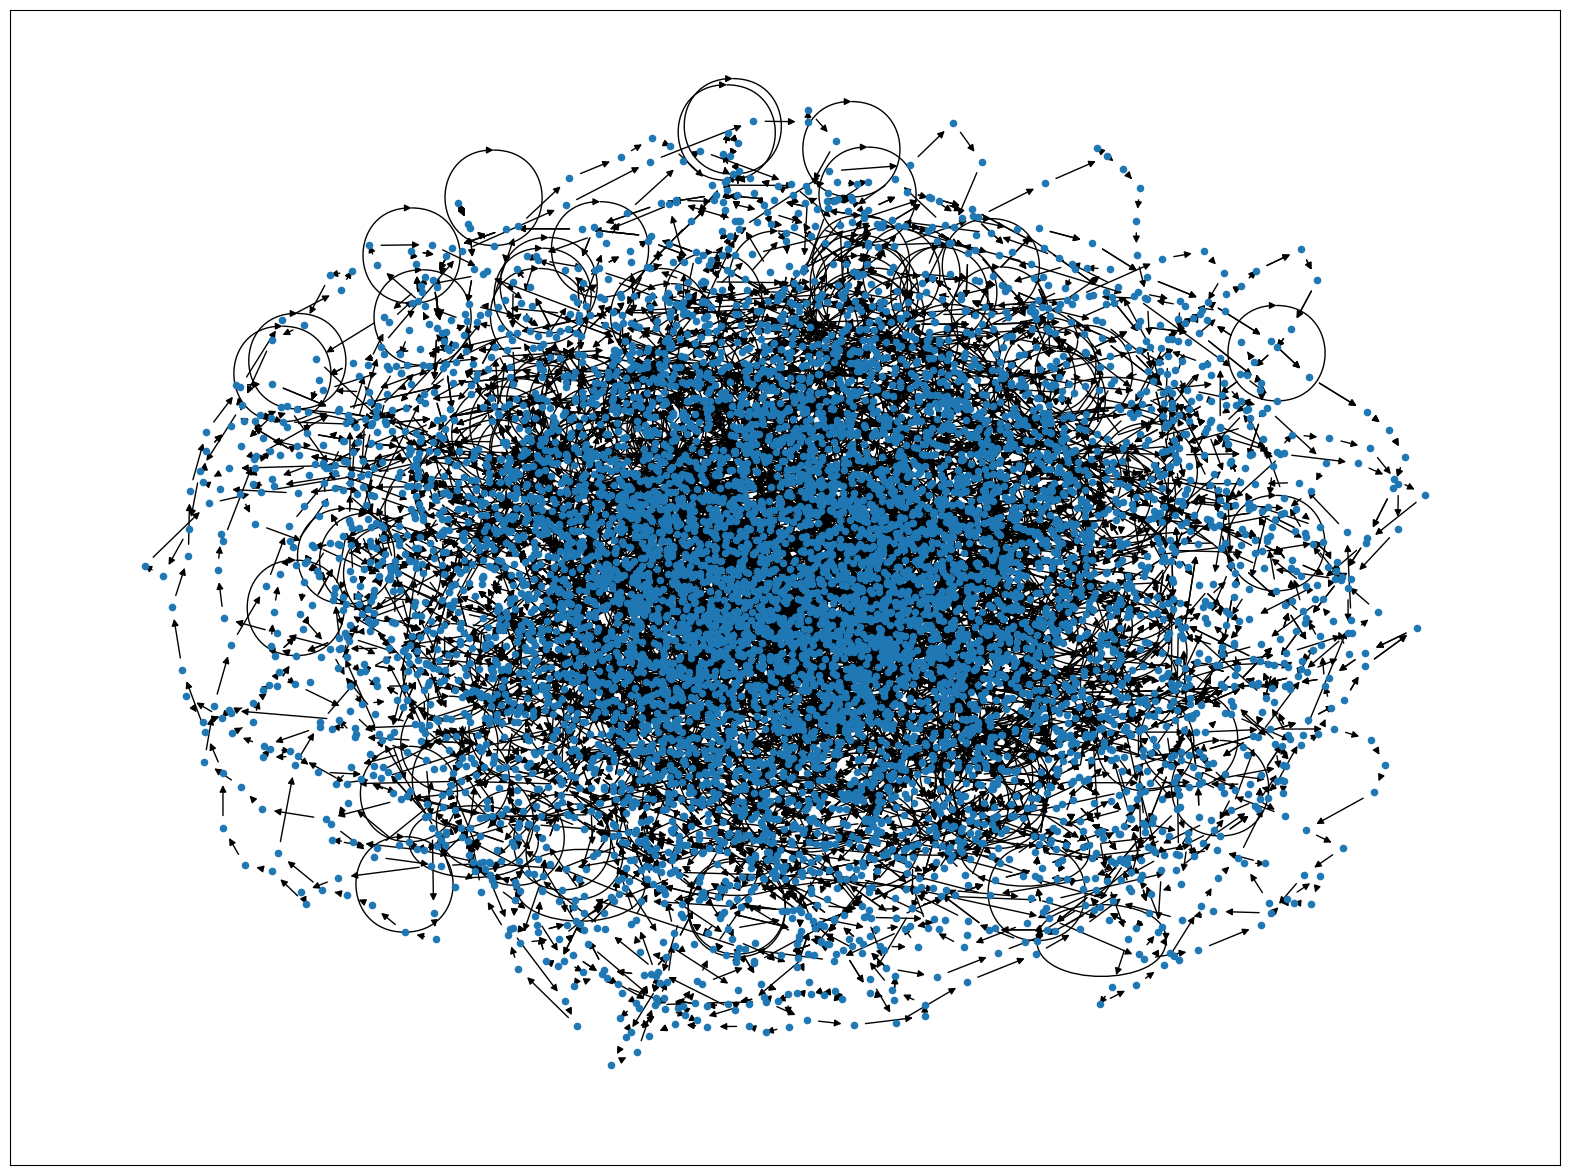

In [ ]:
#visualize the graph
plt.figure(figsize = (20, 15))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 20)
nx.draw_networkx_edges(G, pos)
plt.show()

MultiDiGraph with 125 nodes and 298 edges


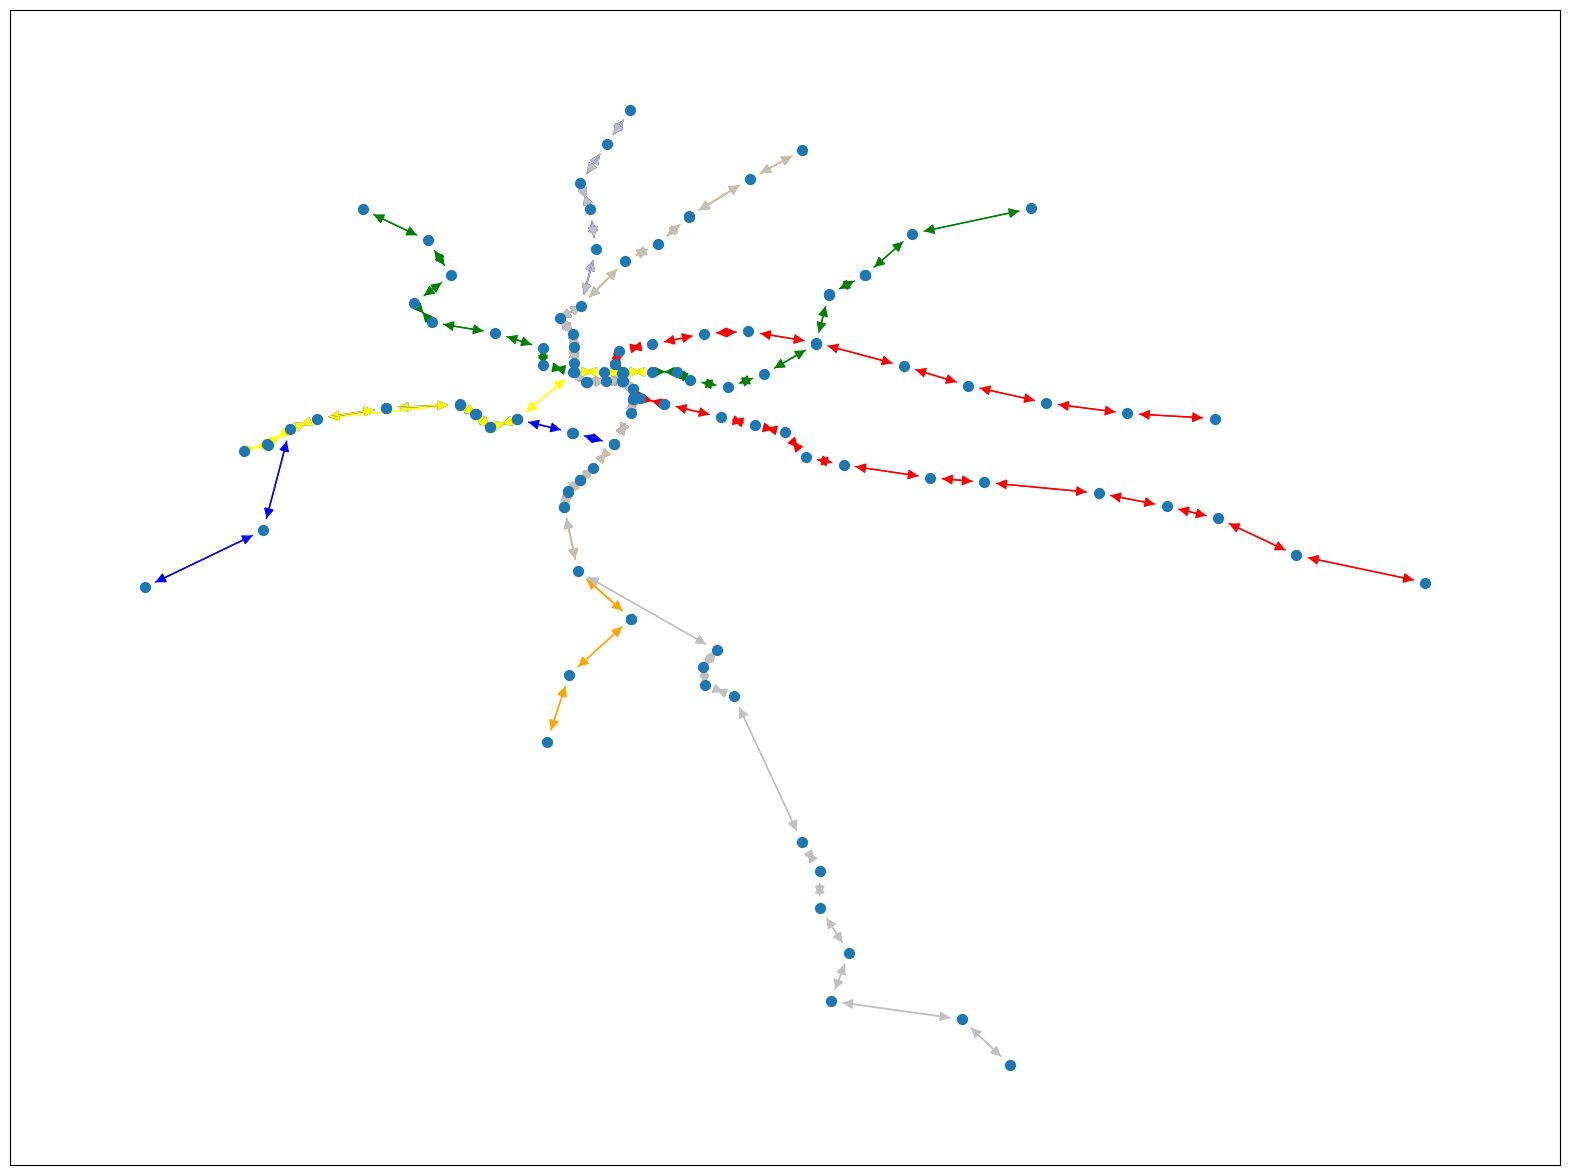

In [ ]:
#to visualize just the stations
station_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['route'] in ['GREEN', 'RED', 'YELLOW', 'ORANGE', 'BLUE', 'SILVER']]
station_nodes = [(u, d) for u, d in G.nodes(data=True) if  d['stop_location_type'] == 'Station']
G_stations = nx.MultiDiGraph()
G_stations.add_nodes_from(station_nodes)
G_stations.add_edges_from(station_edges)
G_stations.remove_edges_from(nx.selfloop_edges(G_stations))
print(G_stations)

#visualize the graph
plt.figure(figsize = (20, 15))
edge_colors = [(d['route']) for u, v, d in G_stations.edges(data=True)]
pos_stat = {}
for u, d in G_stations.nodes(data = True):
    pos_stat[u] = [d['stop_lat'], d['stop_lon']]


nx.draw_networkx_nodes(G_stations, pos_stat, node_size = 50)
nx.draw_networkx_edges(G_stations, pos_stat, edge_color=edge_colors, arrowsize= 15)
plt.show()

Testing/Trail and Error

In [ ]:
#doing this as a test because we need a unique id for each unique route
trips_grouped_test = trips_df.groupby(by = ['route_id', 'direction_id'])['trip_id'].agg(list) #group by route and directions to get all trips for that direction
# trips_grouped_test
trips_test = trips_grouped_test.reset_index() #reset index
trips_test = trips_test.explode('trip_id', ignore_index= True) #one row per trip

trips_test = trips_test.merge(stop_times_df, left_on = 'trip_id', right_on = 'trip_id').sort_values(by = ['trip_id', 'stop_sequence'] )
trips_test = trips_test.groupby(by = ['route_id', 'direction_id', 'trip_id'])['stop_id'].agg(list).reset_index()
trips_test['stop_id'] = trips_test['stop_id'].apply(tuple)
trips_test = trips_test.drop_duplicates(['route_id', 'direction_id', 'stop_id'])
trips_test['unique_id'] = trips_test['route_id'] + trips_test['direction_id'].astype(str) + trips_test['trip_id']

trips_test = trips_test.loc[:, ['unique_id', 'route_id', 'direction_id', 'trip_id']]
#add stop_times
trips_test = trips_test.merge(stop_times_df, left_on = 'trip_id', right_on = 'trip_id')

#a little cleaning of the dates
trips_test['arrival_time'] = trips_test['arrival_time'].apply(parse_times)
trips_test['departure_time'] =  trips_test['departure_time'].apply(parse_times)
trips_test['prev_stop_id'] = trips_test.groupby(by = ['unique_id'])['stop_id'].shift(1, fill_value = 'first')
trips_test

,unique_id,route_id,direction_id,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,A11010266070,A11,0,10266070,14:26:00,14:26:00,21629,2,<NA>,0,0,NaN,1
1,A11010266070,A11,0,10266070,14:27:36,14:27:36,14218,3,<NA>,0,0,NaN,0
2,A11010266070,A11,0,10266070,14:28:05,14:28:05,11648,4,<NA>,0,0,NaN,0
3,A11010266070,A11,0,10266070,14:29:27,14:29:27,11642,5,<NA>,0,0,NaN,0
4,A11010266070,A11,0,10266070,14:29:46,14:29:46,14219,6,<NA>,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17169,YELLOW19075098_20387,YELLOW,1,9075098_20387,06:36:00,06:36:00,PF_C11_2,6,<NA>,0,0,5.9456,<NA>
17170,YELLOW19075098_20387,YELLOW,1,9075098_20387,06:39:00,06:39:00,PF_C12_C,7,<NA>,0,0,7.4669,<NA>
17171,YELLOW19075098_20387,YELLOW,1,9075098_20387,06:40:00,06:40:00,PF_C13_C,8,<NA>,0,0,8.1578,<NA>
17172,YELLOW19075098_20387,YELLOW,1,9075098_20387,06:42:00,06:42:00,PF_C14_2,9,<NA>,0,0,8.8642,<NA>


In [ ]:
#test but better version done above
#there are several trips that go in the same direction. Overall there are two directions: 0 - Travel in one direction (e.g. outbound travel).
#1 - Travel in the opposite direction (e.g. inbound travel).
#we do not need every single trip that occurs every single day so we will aggregate and maybe apply some frequency attributes later on


trips_grouped = trips_df.groupby(by = ['route_id', 'direction_id'])['trip_id'].agg(list) #group by route and directions to get all trips for that direction

trips_grouped = trips_grouped.reset_index() #reset index
trips_grouped = trips_grouped.explode('trip_id', ignore_index= True) #one row per trip

trips_info = trips_grouped.merge(stop_times_df, left_on = 'trip_id', right_on = 'trip_id')
#a little cleaning of the dates
trips_info['arrival_time'] = trips_info['arrival_time'].apply(parse_times)
trips_info['departure_time'] =  trips_info['departure_time'].apply(parse_times)
trips_info['prev_stop_id'] = trips_info.groupby(by = ['route_id', 'direction_id', 'trip_id'])['stop_id'].shift(1, fill_value = 'first')
trips_info


,route_id,direction_id,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,prev_stop_id
0,A11,0,10266070,1900-01-01 14:26:00,1900-01-01 14:26:00,21629,2,<NA>,0,0,NaN,1,first
1,A11,0,10266070,1900-01-01 14:27:36,1900-01-01 14:27:36,14218,3,<NA>,0,0,NaN,0,first
2,A11,0,10266070,1900-01-01 14:28:05,1900-01-01 14:28:05,11648,4,<NA>,0,0,NaN,0,first
3,A11,0,10266070,1900-01-01 14:29:27,1900-01-01 14:29:27,11642,5,<NA>,0,0,NaN,0,first
4,A11,0,10266070,1900-01-01 14:29:46,1900-01-01 14:29:46,14219,6,<NA>,0,0,NaN,0,first
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5673015,YELLOW,1,9076555_20387,1900-01-01 23:38:00,1900-01-01 23:38:00,PF_C11_2,9,<NA>,0,0,7.3951,<NA>,first
5673016,YELLOW,1,9076555_20387,1900-01-01 23:41:00,1900-01-01 23:41:00,PF_C12_C,10,<NA>,0,0,8.9163,<NA>,first
5673017,YELLOW,1,9076555_20387,1900-01-01 23:42:00,1900-01-01 23:42:00,PF_C13_C,11,<NA>,0,0,9.6072,<NA>,first
5673018,YELLOW,1,9076555_20387,1900-01-01 23:44:00,1900-01-01 23:44:00,PF_C14_2,12,<NA>,0,0,10.3136,<NA>,first


In [ ]:
#not used in final version
#now figure out a way to get the mean times based on route, direction, stop id, stop sequence
trips_final = trips_info.groupby(by = ['route_id', 'direction_id', 'stop_sequence', 'stop_id', 'prev_stop_id']).agg(
        mean_arrival_time = ('arrival_time', 'mean'),
        mean_departure_time = ('departure_time', 'mean'),
        mean_shape_dist_traveled = ('shape_dist_traveled', 'mean'),
    ).reset_index()
trips_final['id'] = trips_final['route_id'] + trips_final['direction_id'].astype(str)

In [ ]:
#testing code
stops_df[stops_df['stop_id'] == "PF_F11_C" ]
trips_final[(trips_final['route_id'] == 'GREEN') & (trips_final['direction_id'] == 0)].shape
trips_info[(trips_info['route_id'] == 'GREEN') & (trips_info['direction_id'] == 0) & (trips_info['stop_id'] == "PF_F03_1") & (trips_info['stop_sequence'] == 1)]
trips_df[trips_df['trip_id'] == "9068043_20387" ]


,route_id,direction_id,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,prev_stop_id
3636396,GREEN,0,9068043_20387,1900-01-02 00:14:00,1900-01-02 00:14:00,PF_F03_1,1,<NA>,0,0,0.0,<NA>,first
3639832,GREEN,0,9073173_20387,1900-01-02 02:14:00,1900-01-02 02:14:00,PF_F03_1,1,<NA>,0,0,0.0,<NA>,first
3642869,GREEN,0,9074880_20387,1900-01-02 02:14:00,1900-01-02 02:14:00,PF_F03_1,1,<NA>,0,0,0.0,<NA>,first
3645213,GREEN,0,9076291_20387,1900-01-02 00:14:00,1900-01-02 00:14:00,PF_F03_1,1,<NA>,0,0,0.0,<NA>,first


For exploration I will focuz on a specifc route: Green. and try to connect/create a simple graph.

In [ ]:
#testing on green line
import networkx as nx
import matplotlib.pyplot as plt

#attempting to create a small graph
G = nx.MultiDiGraph()#create empty graph


usable_stops_df = stops_df[(stops_df['location_type'] == 1) |(stops_df['location_type'] == 0)]
nodes_info = []
#converting nodes data to dictionary for adding
for index, row in usable_stops_df.iterrows():
    #label location types
    if row['location_type'] == 1:
        location_type = "Station"
    elif row['location_type'] == 0:
        continue
    else:
        continue #in case we didn't filter correctly

    # print("adding node: ", index)#progress print
    node_id = row['stop_id']
    node_attributes = {"stop_name": row['stop_name'],
                       "stop_lat": row['stop_lat'],
                       "stop_lon": row['stop_lon'],
                       "stop_location_type": location_type,
                       "stop_wheelchair_accessible": row['wheelchair_boarding']}
    #add to nodes_info
    nodes_info.append((node_id, node_attributes))

print(f"Ensuring correct format: {nodes_info[:2]}")

#add nodes
G.add_nodes_from(nodes_info)

print(G)

Ensuring correct format: [('STN_A01_C01', {'stop_name': 'Metro Center', 'stop_lat': 38.89832112, 'stop_lon': -77.02808839, 'stop_location_type': 'Station', 'stop_wheelchair_accessible': 1}), ('STN_A02', {'stop_name': 'Farragut North', 'stop_lat': 38.90314683, 'stop_lon': -77.03966844, 'stop_location_type': 'Station', 'stop_wheelchair_accessible': 1})]
MultiDiGraph with 98 nodes and 0 edges


In [ ]:
stop_times_df[stop_times_df.trip_id == "9067178_20387"].copy().sort_values(by = 'stop_sequence')

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
5419049,9067178_20387,16:19:00,16:19:00,PF_E10_C,1,<NA>,0,0,0.0000,<NA>
5419050,9067178_20387,16:23:00,16:23:00,PF_E09_C,2,<NA>,0,0,2.4989,<NA>
5419051,9067178_20387,16:26:00,16:26:00,PF_E08_2,3,<NA>,0,0,4.3688,<NA>
5419052,9067178_20387,16:28:00,16:28:00,PF_E07_2,4,<NA>,0,0,5.7250,<NA>
5419053,9067178_20387,16:31:00,16:31:00,PF_E06_C,5,<NA>,0,0,7.7078,<NA>
5419054,9067178_20387,16:34:00,16:34:00,PF_E05_C,6,<NA>,0,0,9.4381,<NA>
5419055,9067178_20387,16:37:00,16:37:00,PF_E04_C,7,<NA>,0,0,10.1873,<NA>
5419056,9067178_20387,16:39:00,16:39:00,PF_E03_C,8,<NA>,0,0,11.0862,<NA>
5419057,9067178_20387,16:41:00,16:41:00,PF_E02_C,9,<NA>,0,0,11.6085,<NA>
5419058,9067178_20387,16:42:00,16:42:00,PF_E01_C,10,<NA>,0,0,12.1979,<NA>


In [ ]:

stop_times_test = stop_times_df[stop_times_df.trip_id == "9067178_20387"].copy().sort_values(by = 'stop_sequence')


#calculate estimated arrival time
stop_times_test['arrival_time'] = pd.to_datetime(stop_times_test['arrival_time'], format='%H:%M:%S')#.dt.time
stop_times_test['departure_time'] = pd.to_datetime(stop_times_test['departure_time'], format='%H:%M:%S')#.dt.time
# stop_times_test['time_taken'] = (stop_times_test['arrival_time'] - stop_times_test['departure_time'].shift(1)) / pd.Timedelta(minutes=1)
stop_times_test['prev_stop_id'] = stop_times_test['stop_id'].shift(1) #previous stop
stop_times_test



,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,prev_stop_id
5419049,9067178_20387,1900-01-01 16:19:00,1900-01-01 16:19:00,PF_E10_C,1,<NA>,0,0,0.0000,<NA>,<NA>
5419050,9067178_20387,1900-01-01 16:23:00,1900-01-01 16:23:00,PF_E09_C,2,<NA>,0,0,2.4989,<NA>,PF_E10_C
5419051,9067178_20387,1900-01-01 16:26:00,1900-01-01 16:26:00,PF_E08_2,3,<NA>,0,0,4.3688,<NA>,PF_E09_C
5419052,9067178_20387,1900-01-01 16:28:00,1900-01-01 16:28:00,PF_E07_2,4,<NA>,0,0,5.7250,<NA>,PF_E08_2
5419053,9067178_20387,1900-01-01 16:31:00,1900-01-01 16:31:00,PF_E06_C,5,<NA>,0,0,7.7078,<NA>,PF_E07_2
5419054,9067178_20387,1900-01-01 16:34:00,1900-01-01 16:34:00,PF_E05_C,6,<NA>,0,0,9.4381,<NA>,PF_E06_C
5419055,9067178_20387,1900-01-01 16:37:00,1900-01-01 16:37:00,PF_E04_C,7,<NA>,0,0,10.1873,<NA>,PF_E05_C
5419056,9067178_20387,1900-01-01 16:39:00,1900-01-01 16:39:00,PF_E03_C,8,<NA>,0,0,11.0862,<NA>,PF_E04_C
5419057,9067178_20387,1900-01-01 16:41:00,1900-01-01 16:41:00,PF_E02_C,9,<NA>,0,0,11.6085,<NA>,PF_E03_C
5419058,9067178_20387,1900-01-01 16:42:00,1900-01-01 16:42:00,PF_E01_C,10,<NA>,0,0,12.1979,<NA>,PF_E02_C


In [ ]:
#tested on green line
#add edges, format: add_weighted_edges_from([(1, 2, 0.5), (3, 1, 0.75)]), (to, from, weight)

edges_info = []

for index, row in stop_times_test.iterrows():
    # trip = row['trip_id']
    current_stop = row['stop_id']
    #handle first stops
    if row['prev_stop_id'] is pd.NA:
        prev_stop = current_stop
    else:
        prev_stop = row['prev_stop_id']
    #calculate time between stops
    weight = (row['arrival_time'] - stop_times_test[stop_times_test['stop_id'] == prev_stop]['departure_time'].item()).total_seconds()/60
    print((prev_stop, current_stop, weight))
    edges_info.append((prev_stop, current_stop, weight))

# edges_info

G.add_weighted_edges_from(edges_info)

('PF_E10_C', 'PF_E10_C', 0.0)
('PF_E10_C', 'PF_E09_C', 4.0)
('PF_E09_C', 'PF_E08_2', 3.0)
('PF_E08_2', 'PF_E07_2', 2.0)
('PF_E07_2', 'PF_E06_C', 3.0)
('PF_E06_C', 'PF_E05_C', 3.0)
('PF_E05_C', 'PF_E04_C', 3.0)
('PF_E04_C', 'PF_E03_C', 2.0)
('PF_E03_C', 'PF_E02_C', 2.0)
('PF_E02_C', 'PF_E01_C', 1.0)
('PF_E01_C', 'PF_F01_C', 2.0)
('PF_F01_C', 'PF_F02_C', 1.0)
('PF_F02_C', 'PF_F03_2', 2.0)
('PF_F03_2', 'PF_F04_C', 2.0)
('PF_F04_C', 'PF_F05_C', 2.0)
('PF_F05_C', 'PF_F06_C', 3.0)
('PF_F06_C', 'PF_F07_C', 2.0)
('PF_F07_C', 'PF_F08_C', 2.0)
('PF_F08_C', 'PF_F09_C', 3.0)
('PF_F09_C', 'PF_F10_C', 3.0)
('PF_F10_C', 'PF_F11_C', 3.0)


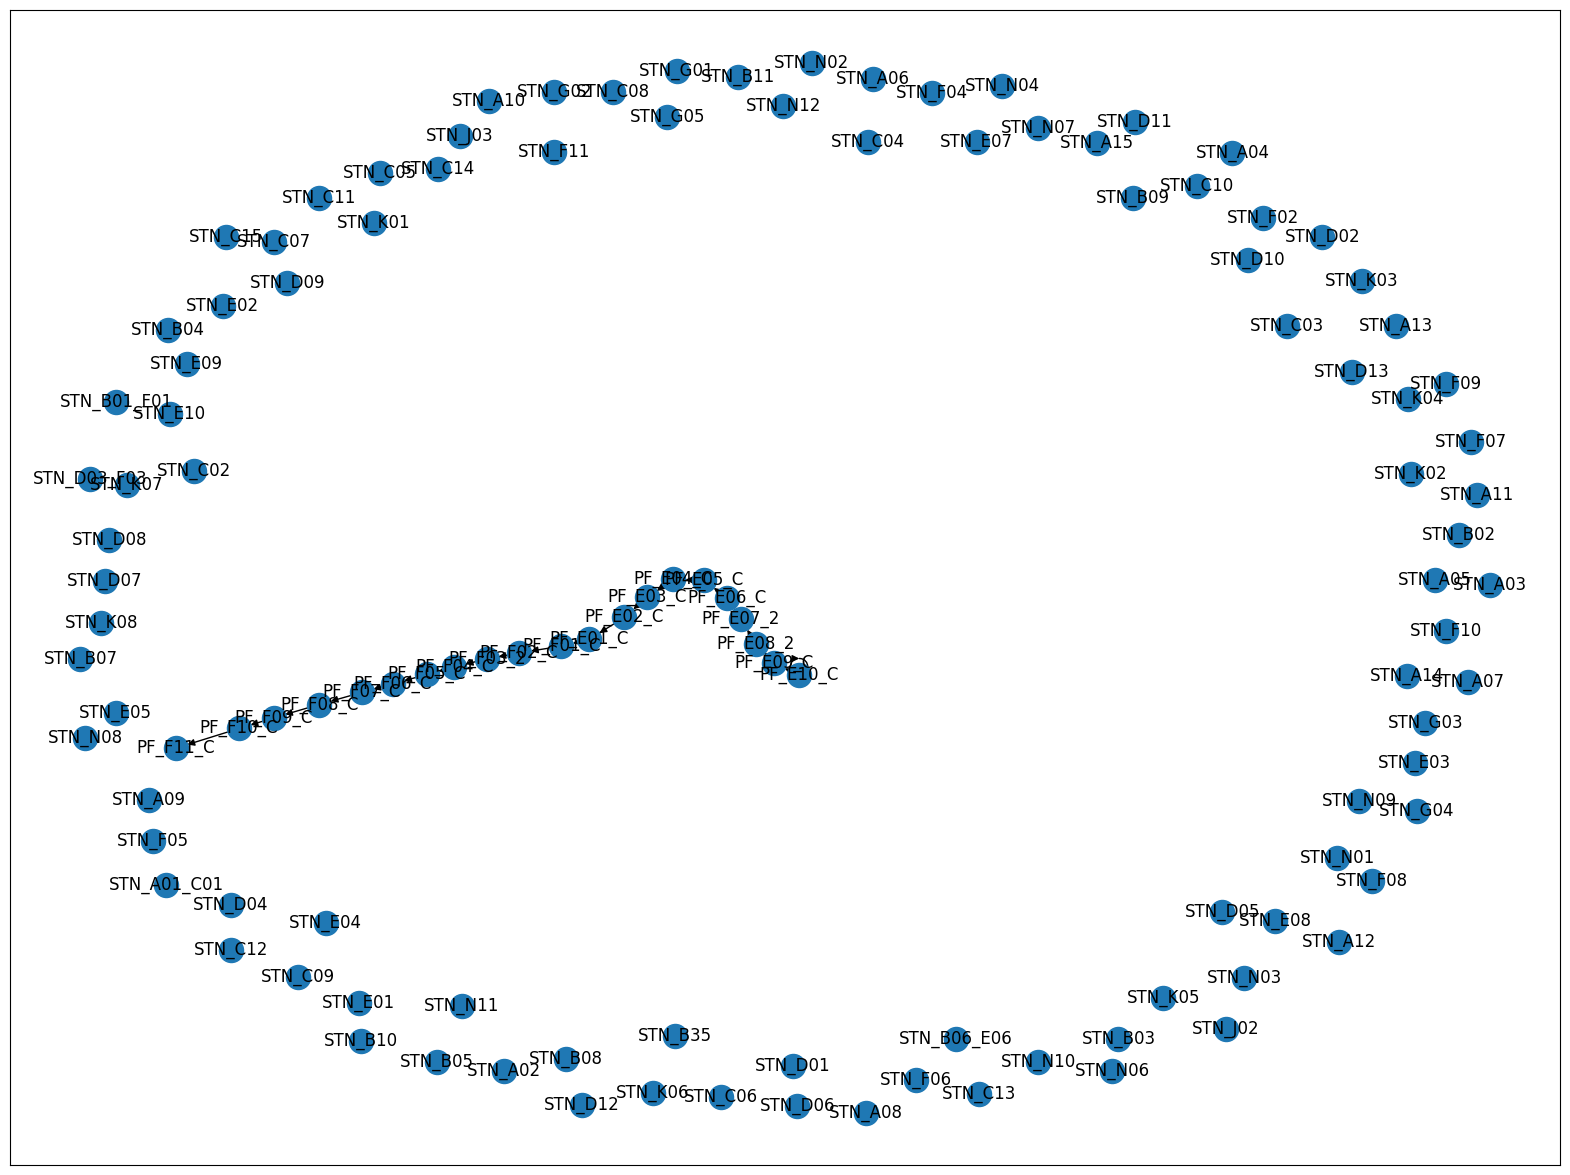

In [ ]:
#visualize the graph
plt.figure(figsize = (20, 15))
nx.draw_networkx(G, with_labels=True)
plt.show()